In [1]:
import pandas as pd
import requests
import numpy as np

font = "Lato"



url = "https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/datasets/consumerpriceindices/current/mm23.csv"
temp = requests.get(url)
temp_file = open("temp.csv", "wb")
temp_file.write(temp.content)
temp_file.close()

RPIdata = pd.read_csv("temp.csv")
RPIdata.columns = RPIdata.iloc[0]
RPIdata = RPIdata.iloc[1:-1]
RPIdata = RPIdata[RPIdata['CDID'].str.contains('Q', regex=False)]
RPIdata = RPIdata[['CDID', 'D7CA', 'D7BT', 'D7DI', 'D7DH', 'D7DG']]
RPIdata.columns = ['date', 'Alcohol', 'Overall', 'Beer', 'Wine', 'Spirits']


/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_16058/1818645420.py:15: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,25

In [2]:
RPIdata

,date,Alcohol,Overall,Beer,Wine,Spirits
230,1948 Q3,NaN,NaN,NaN,NaN,NaN
231,1948 Q4,NaN,NaN,NaN,NaN,NaN
232,1949 Q1,NaN,NaN,NaN,NaN,NaN
233,1949 Q2,NaN,NaN,NaN,NaN,NaN
234,1949 Q3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
524,2022 Q1,104.5,115.9,108.8,104.9,101.2
525,2022 Q2,105.1,120.9,109.4,104.9,102.3
526,2022 Q3,106.5,123.2,111.0,106.2,103.7
527,2022 Q4,107.1,126.7,112.8,106.5,104.0


In [3]:
url2 = "https://www.ons.gov.uk/generator?format=csv&uri=/economy/grossdomesticproductgdp/timeseries/nrjr/ukea"
temp = "temp.csv"

response = requests.get(url2)
with open(temp, "wb") as file:
    file.write(response.content)

Incomedata = pd.read_csv(temp)
Incomedata = Incomedata.iloc[:-7]
Incomedata.columns = ["date", "Incomes"]
Incomedata = Incomedata[Incomedata["date"].str.contains("Q", regex=False)]

In [4]:
Incomedata

,date,Incomes
82,1955 Q1,73960
83,1955 Q2,76478
84,1955 Q3,76502
85,1955 Q4,75175
86,1956 Q1,77301
...,...,...
343,2020 Q2,354718
344,2020 Q3,363668
345,2020 Q4,363789
346,2021 Q1,364392


In [5]:
# Merge the dataframes
Affordability = pd.merge(RPIdata, Incomedata, how='inner', on='date')

# Filter rows where 'Alcohol' column is not empty
Affordability = Affordability[Affordability['Alcohol'] != '']

# Convert the specified columns to numeric and rebase them
for col in ['Alcohol', 'Overall', 'Beer', 'Wine', 'Spirits', 'Incomes']:
    Affordability[col] = pd.to_numeric(Affordability[col])
    Affordability[col] = Affordability[col] * 100 / Affordability.loc[Affordability['date'] == '1988 Q1', col].values[0]

# Calculate affordability using NHS England approach
Affordability['RAPI_all'] = Affordability['Alcohol'] * 100 / Affordability['Overall']
Affordability['RAPI_beer'] = Affordability['Beer'] * 100 / Affordability['Overall']
Affordability['RAPI_wine'] = Affordability['Wine'] * 100 / Affordability['Overall']
Affordability['RAPI_spirits'] = Affordability['Spirits'] * 100 / Affordability['Overall']
Affordability['Affordability_all'] = Affordability['Incomes'] * 100 / Affordability['RAPI_all']
Affordability['Affordability_beer'] = Affordability['Incomes'] * 100 / Affordability['RAPI_beer']
Affordability['Affordability_wine'] = Affordability['Incomes'] * 100 / Affordability['RAPI_wine']
Affordability['Affordability_spirits'] = Affordability['Incomes'] * 100 / Affordability['RAPI_spirits']

# Extract Year and calculate time
Affordability['Year'] = Affordability['date'].str[:4].astype(int)
conditions = [
    Affordability['date'].str[6:8] == '1',
    Affordability['date'].str[6:8] == '2',
    Affordability['date'].str[6:8] == '3'
]
choices = [
    pd.to_datetime(Affordability['Year'].astype(str) + '-01-01'),
    pd.to_datetime(Affordability['Year'].astype(str) + '-04-01'),
    pd.to_datetime(Affordability['Year'].astype(str) + '-07-01')
]
Affordability['time'] = np.select(conditions, choices, default=pd.to_datetime(Affordability['Year'].astype(str) + '-10-01'))


In [6]:
Affordability

,date,Alcohol,Overall,Beer,Wine,Spirits,Incomes,RAPI_all,RAPI_beer,RAPI_wine,RAPI_spirits,Affordability_all,Affordability_beer,Affordability_wine,Affordability_spirits,Year,time
0,1955 Q1,NaN,NaN,NaN,NaN,NaN,41.791686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955,1955-01-01
1,1955 Q2,NaN,NaN,NaN,NaN,NaN,43.214502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955,1955-04-01
2,1955 Q3,NaN,NaN,NaN,NaN,NaN,43.228063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955,1955-07-01
3,1955 Q4,NaN,NaN,NaN,NaN,NaN,42.478231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1955,1955-10-01
4,1956 Q1,NaN,NaN,NaN,NaN,NaN,43.679544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956,1956-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2020 Q2,187.934186,223.251029,162.198795,194.061303,197.656250,200.436225,84.180659,72.653101,86.925155,88.535426,238.102467,275.881170,230.584835,226.390986,2020,2020-04-01
262,2020 Q3,186.471664,224.074074,160.993976,193.678161,194.140625,205.493493,83.218759,71.848551,86.434882,86.641271,246.931697,286.009237,237.743709,237.177377,2020,2020-07-01
263,2020 Q4,184.460695,224.279835,158.734940,191.954023,191.992188,205.561865,82.245778,70.775395,85.586840,85.603856,249.936071,290.442554,240.179292,240.131549,2020,2020-10-01
264,2021 Q1,187.751371,224.691358,161.897590,195.210728,195.898438,205.902595,83.559676,72.053323,86.879500,87.185568,246.413826,285.764190,236.997906,236.165915,2021,2021-01-01


AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

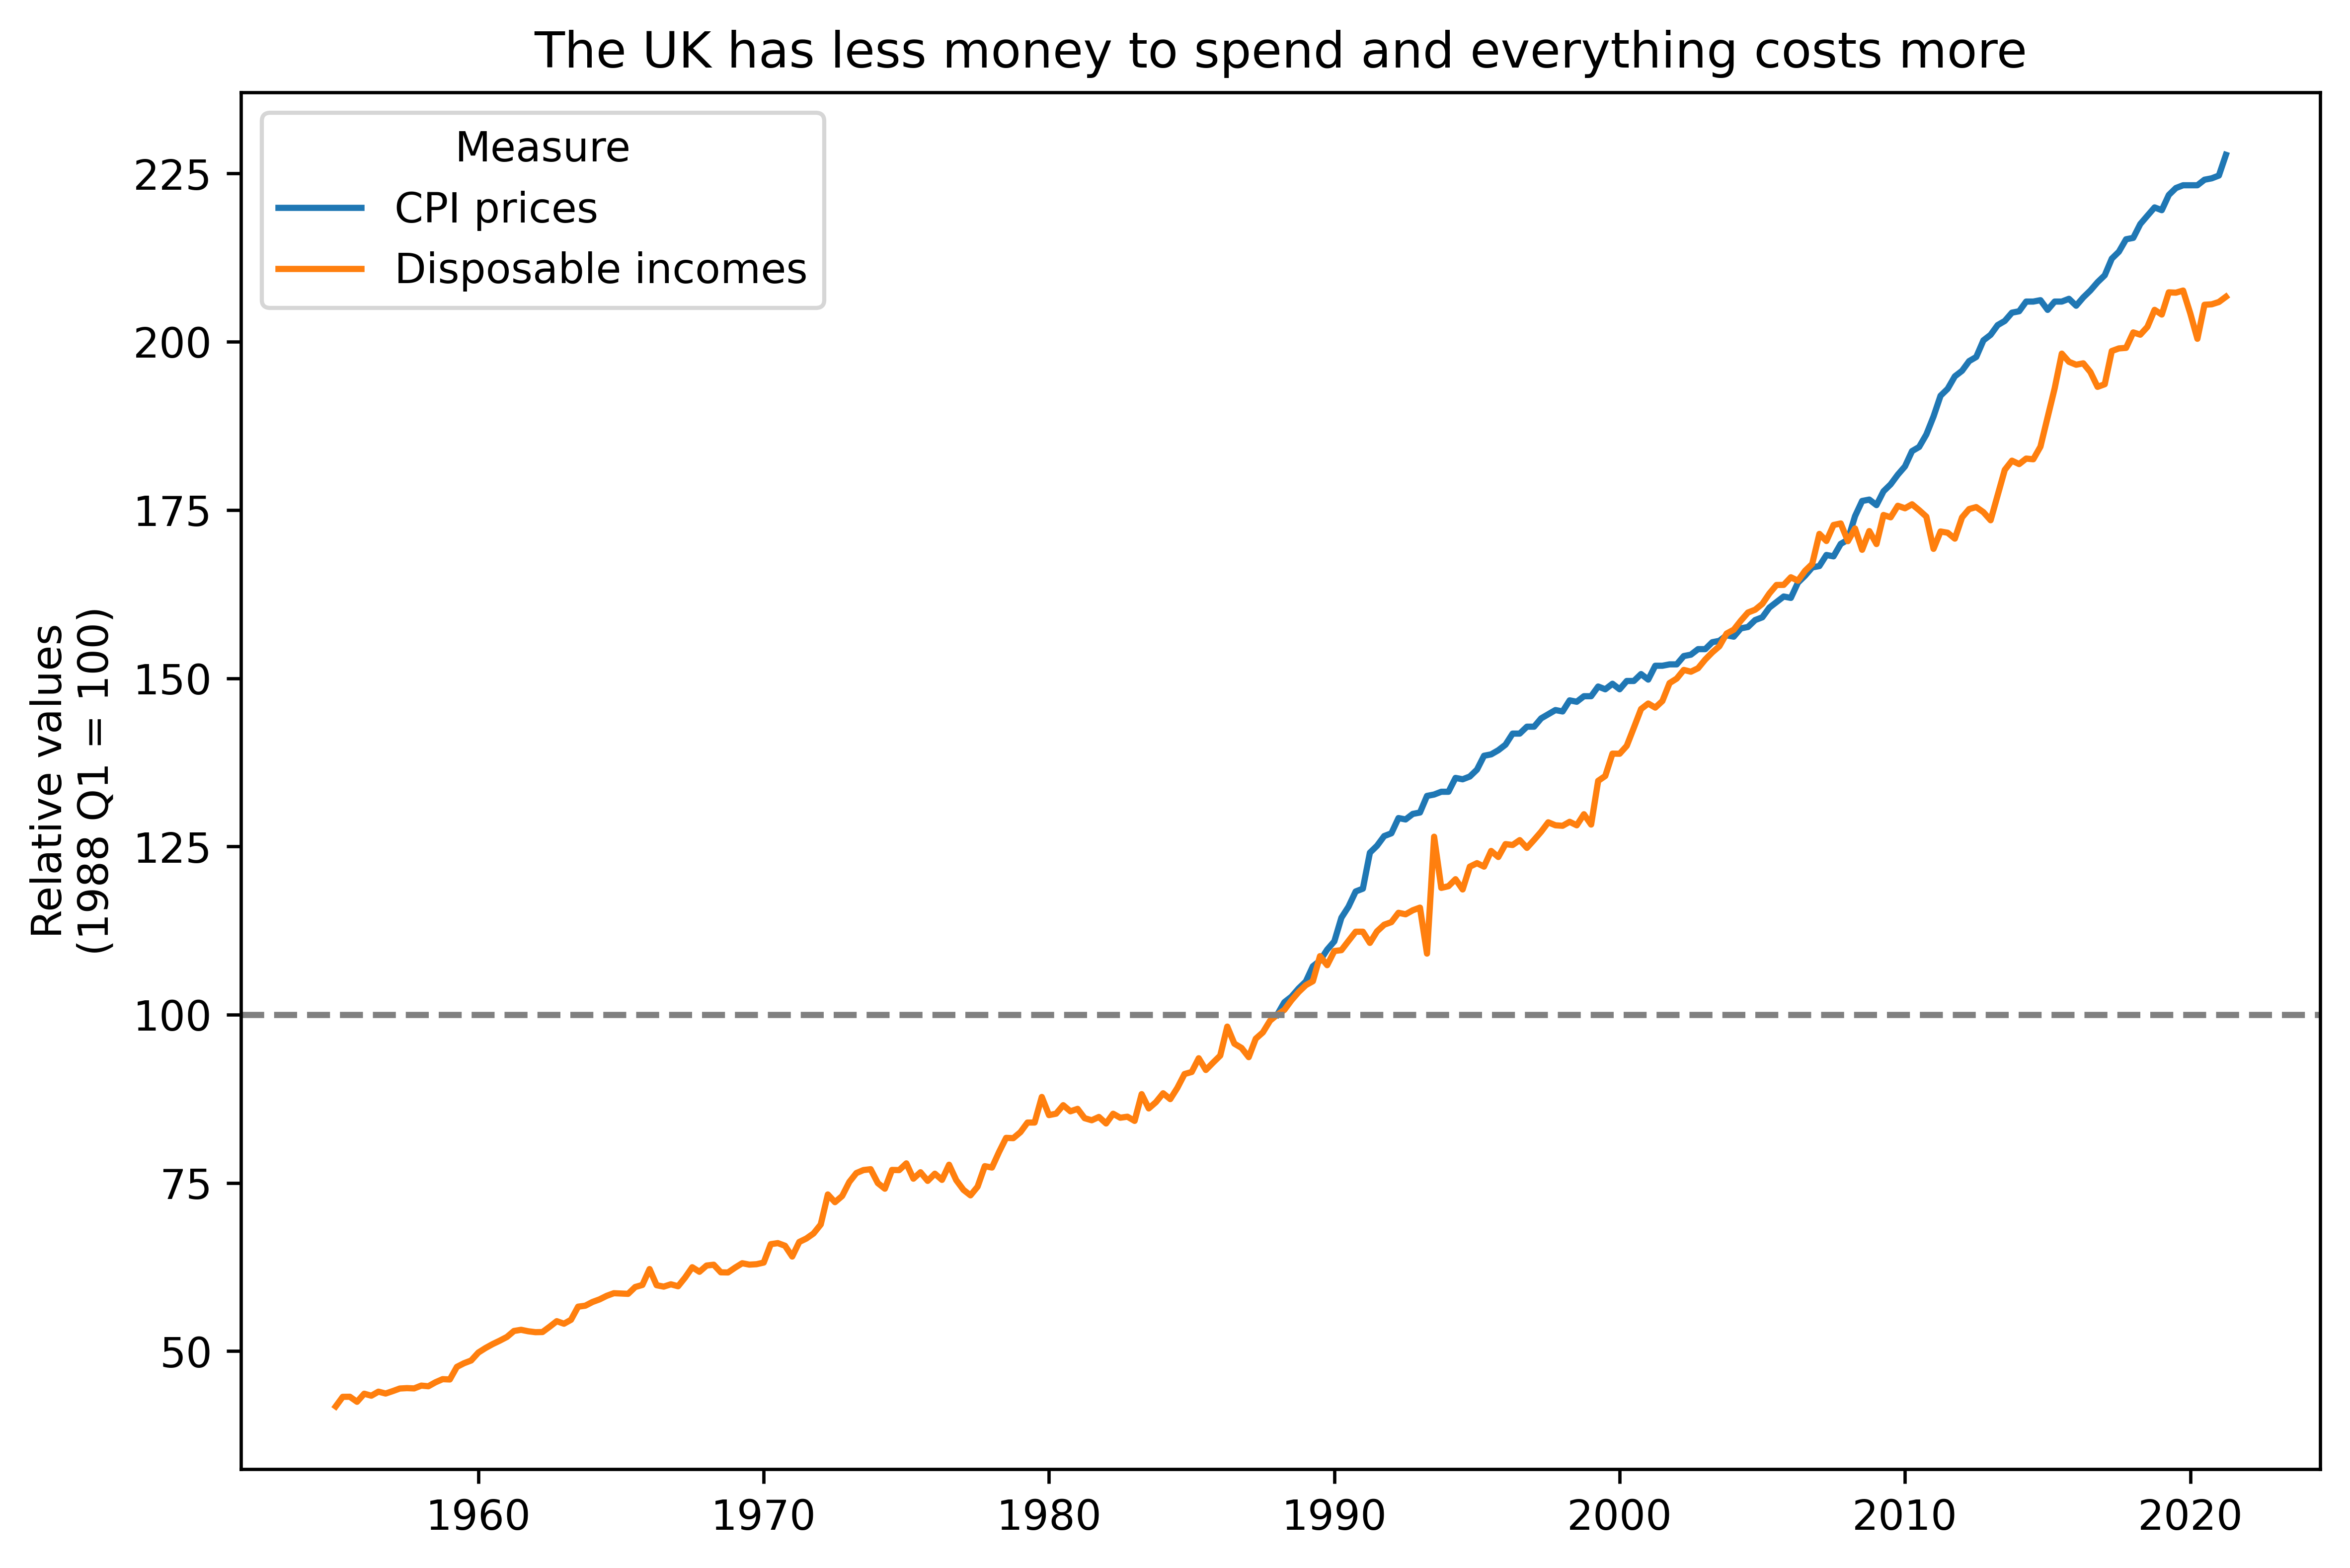

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the summary data
Summarydata = Affordability.filter(regex='time|^RAPI|^Affordability')
Summarydata = Summarydata.melt(id_vars='time', var_name='Metric_Product', value_name='Value')
Summarydata[['Metric', 'Product']] = Summarydata['Metric_Product'].str.split('_', expand=True)
Summarydata = Summarydata.drop(columns='Metric_Product')

# Plot the data
plt.figure(figsize=(9,6), dpi=600)
plot_data = Affordability[['time', 'Overall', 'Incomes']].melt(id_vars='time', var_name='Measure', value_name='Value')
plot_data['Measure'] = np.where(plot_data['Measure'] == 'Overall', 'CPI prices', 'Disposable incomes')
plot_data['vjust'] = np.where(plot_data['Measure'] == 'CPI prices', -0.5, 1.5)

sns.lineplot(data=plot_data, x='time', y='Value', hue='Measure')
plt.axhline(y=100, color='grey', linestyle='--')
plt.xlabel('')
plt.ylabel('Relative values\n(1988 Q1 = 100)')
plt.title('The UK has less money to spend and everything costs more')
plt.subtitle('Overall CPI prices and disposable household income relative to Q1 1988. Data up to September 2022.')
plt.legend(title='')
# ...add additional customization as necessary...
plt.savefig('Outputs/DisposableIncomes.tiff')


FileNotFoundError: [Errno 2] No such file or directory: 'Outputs/AlcoholCPI.tiff'

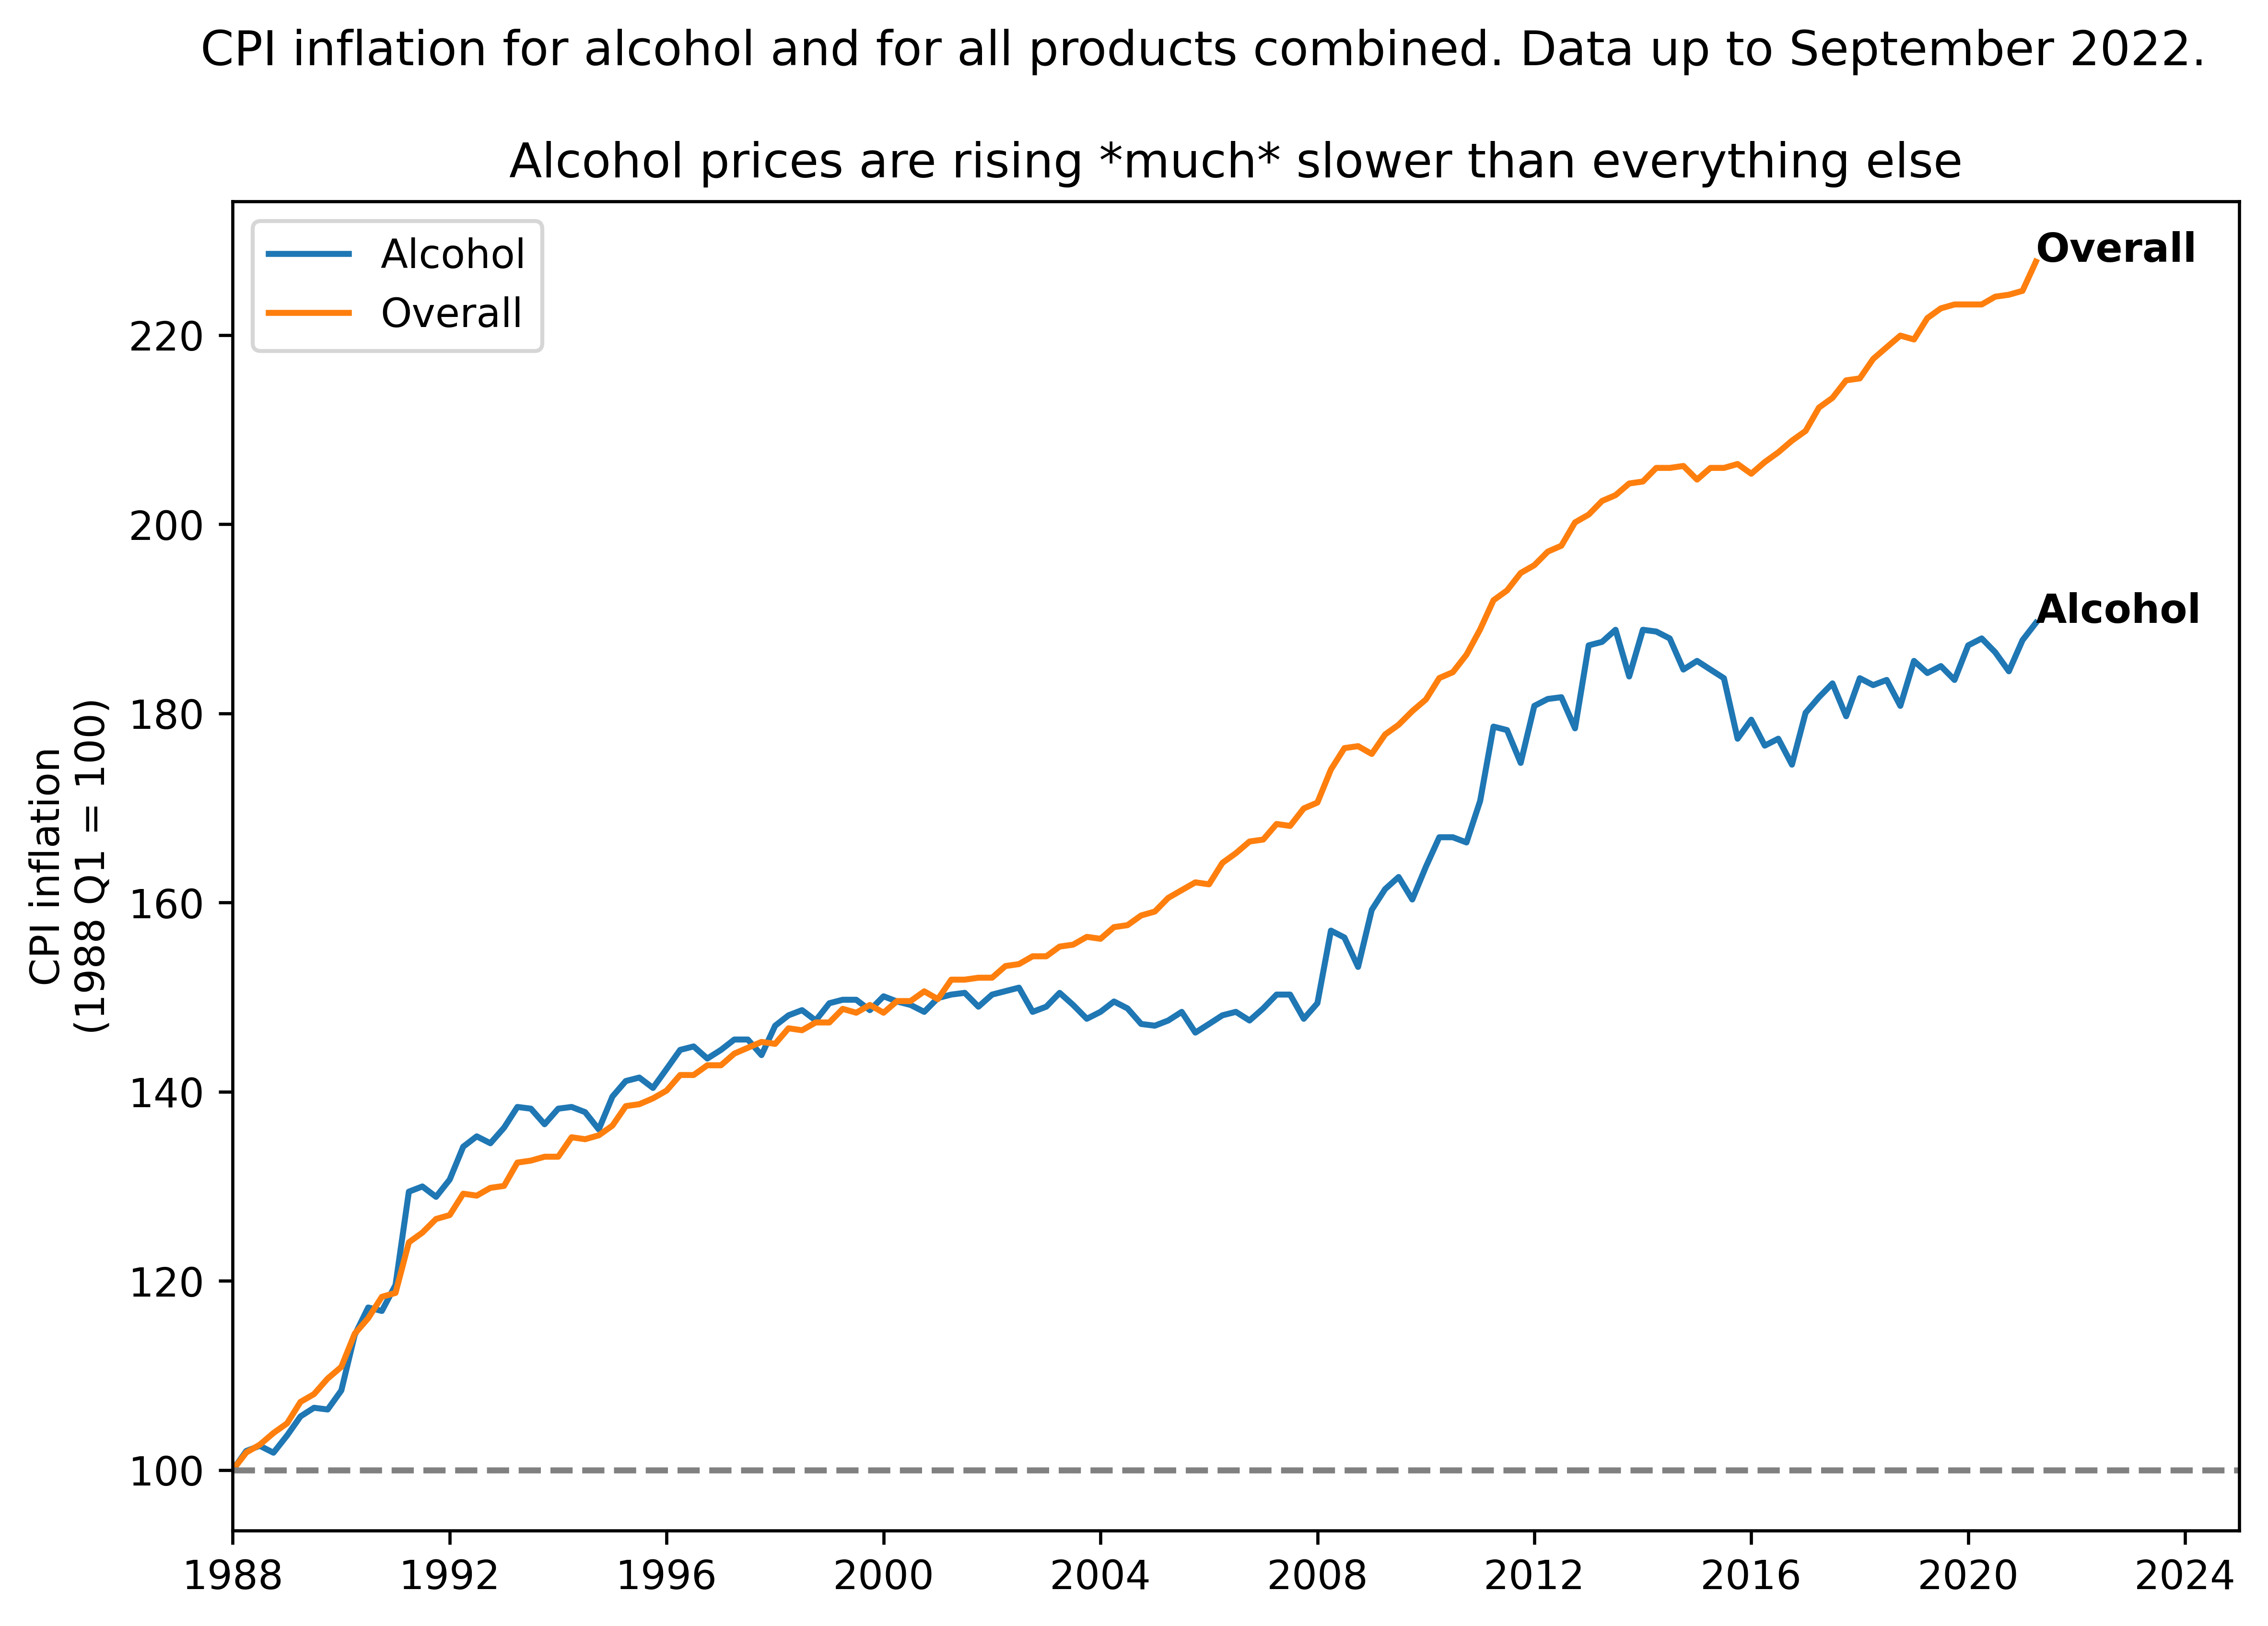

In [12]:
# Plot the data
plt.figure(figsize=(9,6), dpi=600)
plot_data = Affordability[['time', 'Alcohol', 'Overall']].melt(id_vars='time', var_name='Measure', value_name='Value')

sns.lineplot(data=plot_data, x='time', y='Value', hue='Measure')
plt.axhline(y=100, color='grey', linestyle='--')

# Annotate last data points
last_date = plot_data['time'].max()
for measure in plot_data['Measure'].unique():
    y_value = plot_data.loc[(plot_data['time'] == last_date) & (plot_data['Measure'] == measure), 'Value'].values[0]
    plt.text(last_date, y_value, measure, fontdict={'family':'Lato', 'fontweight':'bold'})

plt.xlabel('')
plt.ylabel('CPI inflation\n(1988 Q1 = 100)')
plt.title('Alcohol prices are rising *much* slower than everything else')
plt.suptitle('CPI inflation for alcohol and for all products combined. Data up to September 2022.')
plt.legend(title='')
plt.xlim(pd.to_datetime('1988-01-01'), pd.to_datetime('2025-01-01'))
# ...add additional customization as necessary...
plt.savefig('Outputs/AlcoholCPI.tiff')
